## Abstract

The ACS PUMS dataset, collected by the U.S. Census Bureau, provides detailed demographic and employment data for thousands of individuals across the United States. In this blog post, we build a machine learning classifier to predict whether an individual is employed using demographic features such as age, education, and marital status. While race is excluded from the predictive features, it is retained as a group label to enable a comprehensive bias audit. By leveraging logistic regression with polynomial feature expansion and tuning model complexity via grid search, our classifier achieved an overall accuracy of approximately 82%. Our analysis not only demonstrates the predictive power of data-driven approaches in employment forecasting but also reveals disparities in error rates and predicted outcomes across racial groups, underscoring the critical need for fairness auditing before deploying such models in commercial or governmental settings.

## Goal of Project

In this project, we are going to build a machine learning classifier that predicts whether an individual is employed using demographic data from the ACS PUMS dataset. We will exclude race from the features used for prediction while retaining it as a group label to later audit the model for racial bias. This approach helps us explore whether the classifier inadvertently displays disparate performance across racial groups. In addition to this, we’ll tune the model’s complexity (using polynomial features with logistic regression) and perform a bias audit, examining overall and subgroup error rates, and statistical parity. Our findings will audit the bias of predictive models when applied to real-world census data.

## Loading Data

Using the folktables package, we will download the ACS PUMS data, which provides demographic and employment information collected by the U.S. Census. For our project, we select data for Michigan from the 2018 1-Year survey. In our code snippet below we will load the data:

In [3]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "MI"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000064,3,1,2907,2,26,1013097,8,60,...,9,0,12,9,11,9,0,9,10,12
1,P,2018GQ0000154,3,1,1200,2,26,1013097,92,20,...,92,91,93,95,93,173,91,15,172,172
2,P,2018GQ0000158,3,1,2903,2,26,1013097,26,54,...,26,52,3,25,25,28,28,50,51,25
3,P,2018GQ0000174,3,1,1801,2,26,1013097,86,20,...,85,12,87,12,87,85,157,86,86,86
4,P,2018GQ0000212,3,1,2600,2,26,1013097,99,33,...,98,96,98,95,174,175,96,95,179,97


## Feature Selection
Below we are going to pick a list of possible feautres that would be used for modeling. We Exclude Target & Group Features: Remove ESR (employment status, which is our target) and RAC1P (race, used later for bias auditing) from the features list.
We then subset the data: By focusing on a smaller set of relevant features, we simplify the model and focus on the factors that are most informative for predicting employment.

In [4]:
possible_features = ['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
print(acs_data[possible_features].head())

features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

   AGEP  SCHL  MAR  RELP  DIS  ESP  CIT  MIG  MIL  ANC  NATIVITY  DEAR  DEYE  \
0    60  15.0    5    17    1  NaN    1  1.0  4.0    1         1     2     2   
1    20  19.0    5    17    2  NaN    1  1.0  4.0    2         1     2     2   
2    54  18.0    3    16    1  NaN    1  1.0  4.0    4         1     2     2   
3    20  18.0    5    17    2  NaN    1  1.0  4.0    4         1     2     2   
4    33  18.0    5    16    2  NaN    1  3.0  4.0    2         1     2     2   

   DREM  SEX  RAC1P  ESR  
0   1.0    1      2  6.0  
1   2.0    2      1  6.0  
2   1.0    1      1  6.0  
3   2.0    1      1  6.0  
4   2.0    1      1  6.0  


## Chosing our Problem
Problem Choice: 
In this project we will be predicting whether an individual is employed (target variable ESR) using demographic features—such as age, education, marital status, and others—while deliberately excluding race (RAC1P) from the predictors. However, we keep the race information aside as the group label. This allows us to later perform a bias audit by comparing model performance across different racial groups. This setup enables us to build a classifier that does not directly use race during training, while still allowing us to measure if the predictions favor one racial group over another helping us assess the bias.

The code below doesteh following steps

* Defines the Prediction Task: We use the BasicProblem class to specify which features to use, the target variable, and how to transform the target (converting ESR values into a binary label).

* We then Extract the Data: The data is converted into a feature matrix, a label vector, and a group vector. 

* After that we do our Train-Test Split: The data is split into training and test sets so that we can train our model and later evaluate its performance.


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
# 3. Define the Prediction Task using BasicProblem
# Here, we aim to predict employment status. The target_transform converts the raw ESR value
# to a binary label (1 for employed if ESR == 1, else 0).
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',          # Use race as the group label for bias analysis later.
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1)
)

# Extract the feature matrix, binary labels, and group indicator from the DataFrame.
features, label, group = EmploymentProblem.df_to_numpy(acs_data)
print("Features shape:", features.shape)
# 4. Train-Test Split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])



Features shape: (99419, 15)
Training set size: 79535
Test set size: 19884


## Descriptive Analysis

Our code below converts the training data into a DataFrame to calculate some basic statistics. We find that there are 79,535 individuals in total. Overall, about 44.3% of these individuals are employed. When we break the data down by the race group (held in the "group" column), we see that Group 1 has 67,415 individuals, Group 2 has 6,881 individuals, and the remaining groups have much smaller numbers. Looking at employment rates within each group, about 45.5% of Group 1 are employed, while Group 2 has a lower rate at around 34.6%. The other groups show employment proportions between roughly 33% and 49%. This simple analysis helps us understand the size and distribution of our data, which is essential for building a fair and well-informed mode

In [9]:
# 5. Descriptive Analysis
# Convert training data into a DataFrame for easy descriptive analysis.

df = pd.DataFrame(X_train, columns=features_to_use)
df["group"] = group_train  # This is the race indicator
df["label"] = y_train      # 1 if employed, 0 otherwise

# Explore the different statistics
total_individuals = df.shape[0]
positive_proportion = df["label"].mean()
group_counts = df["group"].value_counts()
group_positive = df.groupby("group")["label"].mean()

print("Total Individuals:", total_individuals)
print("Overall Proportion Employed:", positive_proportion)
print("Number of Individuals by Group:\n", group_counts)
print("Employment Proportion by Group:\n", group_positive)


Total Individuals: 79535
Overall Proportion Employed: 0.44297479097252784
Number of Individuals by Group:
 group
1    67415
2     6881
6     2061
9     1922
8      670
3      467
5       95
7       24
Name: count, dtype: int64
Employment Proportion by Group:
 group
1    0.454825
2    0.345880
3    0.419700
5    0.400000
6    0.492479
7    0.458333
8    0.444776
9    0.328824
Name: label, dtype: float64


We also the "SEX" attribute and calculate employment rates for each race-sex combination. For example, in Group 1, males are employed at about 45.6% and females at 45.4%, while in Group 2, rates are around 34.4% for males and 34.8% for females. This helps identify any intersectional disparities.

In [11]:
# Intersectional analysis: using an additional sensitive attribute (e.g., SEX)
# Assuming the original acs_data contains the SEX column:
df["sex"] = acs_data["SEX"]
intersection = df.groupby(["group", "sex"])["label"].mean().reset_index()
print("Intersectional Employment Proportions:\n", intersection)


Intersectional Employment Proportions:
     group  sex     label
0       1    1  0.455874
1       1    2  0.453794
2       2    1  0.344051
3       2    2  0.347688
4       3    1  0.384615
5       3    2  0.451220
6       5    1  0.428571
7       5    2  0.369565
8       6    1  0.486829
9       6    2  0.498069
10      7    1  0.416667
11      7    2  0.500000
12      8    1  0.448753
13      8    2  0.440129
14      9    1  0.339112
15      9    2  0.319319


Our Graph below plots the proprtions of employment amongst all the different races. This bar chart shows the proportion of employed individuals broken down by race group and sex. Each pair of bars compares males (blue) and females (orange) within the same race group. By comparing the heights of the bars, we can quickly see people of white have higher employment rates compared to people of black race who contrarily have this graph aslo shows us whether there are notable differences between males and females in each group.

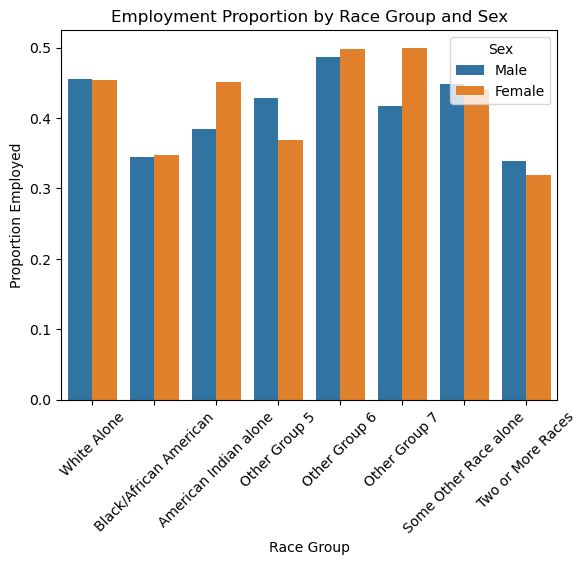

In [34]:
# Map numeric group codes to more descriptive labels
group_map = {
    1: "White Alone",
    2: "Black/African American",
    3: "American Indian alone",
    5: "Other Group 5",
    6: "Other Group 6",
    7: "Other Group 7",
    8: "Some Other Race alone",
    9: "Two or More Races"
}

# Map numeric sex codes to more descriptive labels
sex_map = {
    1: "Male",
    2: "Female"
}

# Apply these mappings to the DataFrame used for plotting
intersection["group_label"] = intersection["group"].map(group_map)
intersection["sex_label"] = intersection["sex"].map(sex_map)

# Plot the results using a bar chart
sns.barplot(data=intersection, x="group_label", y="label", hue="sex_label")
plt.xlabel("Race Group")
plt.ylabel("Proportion Employed")
plt.title("Employment Proportion by Race Group and Sex")
plt.xticks(rotation=45)  # Rotate x labels if they're too long
plt.legend(title="Sex")
plt.show()


## Training our model
Below, we begin training our model to predict whether an individual is employed based on their demographic features (excluding race). We set up a pipeline that performs three main steps:

* PolynomialFeatures: Expands the original features to include interaction terms and higher-order terms, allowing the model to capture more complex relationships.

* StandardScaler: Normalizes these expanded features so that no single feature dominates because of its scale.

* LogisticRegression: Fits a logistic regression classifier to predict employment (employed vs. not employed).

We then use a parameter grid (param_grid) to tune two key aspects:

* polynomialfeatures__degree controls how many polynomial and interaction terms we create (from no expansion at degree 1, to quadratic expansion at degree 2).

* logisticregression__C controls the regularization strength of the logistic regression model, balancing the trade-off between overfitting and underfitting.

This setup, combined with grid search, systematically tests different combinations of polynomial degrees and regularization strengths, helping us figure out the best model configuration for our prediction task.

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create a pipeline with PolynomialFeatures, StandardScaler, and LogisticRegression.
# PolynomialFeatures adds interaction terms and higher order terms, increasing model complexity.
pipeline = make_pipeline(
    PolynomialFeatures(), 
    StandardScaler(), 
    LogisticRegression(max_iter=1000)
)
# Define a grid of parameters to tune:
# - polynomialfeatures__degree: The degree of the polynomial features (1 = no expansion, 2 = quadratic, etc.)
# - logisticregression__C: Regularization strength for logistic regression.
param_grid = {
    'polynomialfeatures__degree': [1, 2],  # Limit the degree to reduce feature explosion
    'logisticregression__C': [0.1, 1, 10]    # A small set of regularization values
}

We use GridSearchCV to perform a 3-fold cross-validation test each combination of polynomial degree and regularization strength. The training set is split into 3 parts, and each model configuration is evaluated on each part. The best parameters are then chosen based on the highest average accuracy, and the final model is trained on the entire training set with those parameters taht we find.

In [21]:

# Perform grid search with 3-fold cross-validation to speed up computation.
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.1, 1, 10],
                         'polynomialfeatures__degree': [1, 2]},
             scoring='accuracy')

## Testing our accuracy
In this section, we test and evaluate our classifier. From our grid search, we found that the best parameters are a polynomial degree of 2 and a regularization strength (C) of 10. This helped us achieved a cross-validation accuracy of about 82.2%, and when we evaluated the model on the test set, we obtained an accuracy of roughly 82.5%. This means that our classifier correctly predicts whether an individual is employed for 82% of the cases in the test set.

In [22]:

# Output the best parameters and cross-validation accuracy.
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

# Evaluate the best model on the test set.
y_pred = grid.predict(X_test)
test_accuracy = (y_pred == y_test).mean()
print("Test Set Accuracy:", test_accuracy)

Best Parameters: {'logisticregression__C': 10, 'polynomialfeatures__degree': 2}
Best Cross-Validation Accuracy: 0.8223675160030627
Test Set Accuracy: 0.8245825789579562


## Auditing Our Model (Overall Measures)

Here we evaluate our model's performance on the test data. We calculate the confusion matrix, which includes true negatives (TN), false positives (FP), false negatives (FN), and true positives (TP). The model's overall accuracy is about 82.5%. Its precision (PPV) shows that around 78% of predicted employed cases were correct. The false negative rate (FNR) indicates that about 15.4% of employed individuals were missed, while the false positive rate (FPR) reveals that roughly 19.3% of non-employed individuals were incorrectly classified as employed. These metrics show us how effective our model is on unseen data.

In [24]:

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.calibration import calibration_curve

# --------------------------
# 1. Overall Measures
# --------------------------
# Compute overall confusion matrix and metrics
# y_test: true labels; y_pred: binary predictions from your best model
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

overall_accuracy = accuracy_score(y_test, y_pred)
overall_ppv = precision_score(y_test, y_pred)  # PPV = precision
overall_fnr = fn / (tp + fn) if (tp + fn) > 0 else np.nan  # false negative rate
overall_fpr = fp / (tn + fp) if (tn + fp) > 0 else np.nan  # false positive rate

print("Overall Accuracy:", overall_accuracy)
print("Overall PPV (Precision):", overall_ppv)
print("Overall False Negative Rate:", overall_fnr)
print("Overall False Positive Rate:", overall_fpr)


Overall Accuracy: 0.8245825789579562
Overall PPV (Precision): 0.7794621534627765
Overall FNR: 0.15375944087476046
Overall FPR: 0.19286298011441025


## Auditing our model (testing by group measures)

Our group metrics reveal how well our model performs across different subgroups. In our by-group analysis, Group 1 (White individuals) has an accuracy of 82.7% and a precision of 78.9%, with a false negative rate of 15.2% and a false positive rate of 19.2%. Group 2 (Black individuals) shows slightly lower performance, with an accuracy of 81.3% and a precision of 70.9%, alongside a higher false negative rate (17.2%). These differences suggest that our model may be less reliable for Black individuals, which is an important insight for our project focused on detecting and addressing racial bias in employment predictions.

In [45]:
# By-Group Measures

# Get the unique groups 
groups = np.unique(group_test)
group_metrics = []

# Loop over each group to calculate the performance metrics
for g in groups:
    idx = (group_test == g)
    # Extract the true labels and predictions for this group
    y_true_g = y_test[idx]
    y_pred_g = y_pred[idx]

    # here we check if the group contains both classes (0 and 1) for a reliable confusion matrix
    if len(np.unique(y_true_g)) < 2:  # Handle cases with only one class
        tn_g = fp_g = fn_g = tp_g = np.nan
    else: # Compute the confusion matrix for the current group
        cm_g = confusion_matrix(y_true_g, y_pred_g)
        try: # Unpack the confusion matrix into true negatives, false positives, false negatives, and true positives
            tn_g, fp_g, fn_g, tp_g = cm_g.ravel()
        except ValueError: # If there's an error (e.g., due to an unexpected shape), assign NaN
            tn_g = fp_g = fn_g = tp_g = np.nan

    # Calculate accuracy: proportion of correct predictions in this group
    acc = accuracy_score(y_true_g, y_pred_g)
    # Calculate precision (PPV): proportion of predicted positives that are actually positive
    ppv = precision_score(y_true_g, y_pred_g, zero_division=0)
    # Calculate false negative rate (FNR): proportion of actual positives that were missed
    fnr = fn_g / (tp_g + fn_g) if (tp_g + fn_g) > 0 else np.nan
    # Calculate false positive rate (FPR): proportion of actual negatives that were incorrectly predicted as positive
    fpr = fp_g / (tn_g + fp_g) if (tn_g + fp_g) > 0 else np.nan

    print(f"\nGroup {g}:")
    print(f"  Count: {np.sum(idx)}")
    print(f"  Accuracy: {acc:.3f}")
    print(f"  PPV (Precision): {ppv:.3f}")
    print(f"  FNR (False Negative Rate): {fnr:.3f}")
    print(f"  FPR (False Positive Rate): {fpr:.3f}")

    group_metrics.append({
        'group': g,
        'count': np.sum(idx),
        'accuracy': acc,
        'ppv': ppv,
        'fnr': fnr,
        'fpr': fpr,
    })



Group 1:
  Count: 16815
  Accuracy: 0.827
  PPV (Precision): 0.789
  FNR (False Negative Rate): 0.152
  FPR (False Positive Rate): 0.192

Group 2:
  Count: 1813
  Accuracy: 0.813
  PPV (Precision): 0.709
  FNR (False Negative Rate): 0.172
  FPR (False Positive Rate): 0.195

Group 3:
  Count: 126
  Accuracy: 0.754
  PPV (Precision): 0.655
  FNR (False Negative Rate): 0.250
  FPR (False Positive Rate): 0.244

Group 5:
  Count: 21
  Accuracy: 0.714
  PPV (Precision): 0.556
  FNR (False Negative Rate): 0.286
  FPR (False Positive Rate): 0.286

Group 6:
  Count: 474
  Accuracy: 0.800
  PPV (Precision): 0.731
  FNR (False Negative Rate): 0.111
  FPR (False Positive Rate): 0.276

Group 7:
  Count: 3
  Accuracy: 0.667
  PPV (Precision): 0.000
  FNR (False Negative Rate): nan
  FPR (False Positive Rate): nan

Group 8:
  Count: 162
  Accuracy: 0.809
  PPV (Precision): 0.815
  FNR (False Negative Rate): 0.195
  FPR (False Positive Rate): 0.188

Group 9:
  Count: 470
  Accuracy: 0.847
  PPV (Prec

## Calculating Bias Measures

**Calibration Curve Analysis:**

* We can see in our calibration curve, which shows how well our model’s predicted probabilities align with the actual outcomes. The blue line (our model’s predictions) is very close to the orange diagonal (perfect calibration), indicating that when our model predicts a probability \( p \) of being employed, roughly \( p\% \) of those individuals are employed. 
From our graph, we can say that our model is well-calibrated overall, which means it does a good job matching predicted probabilities to real-world outcomes. However, calibration alone does not guarantee fairness, so we still need to check subgroup performance to ensure the model treats different groups equitably.


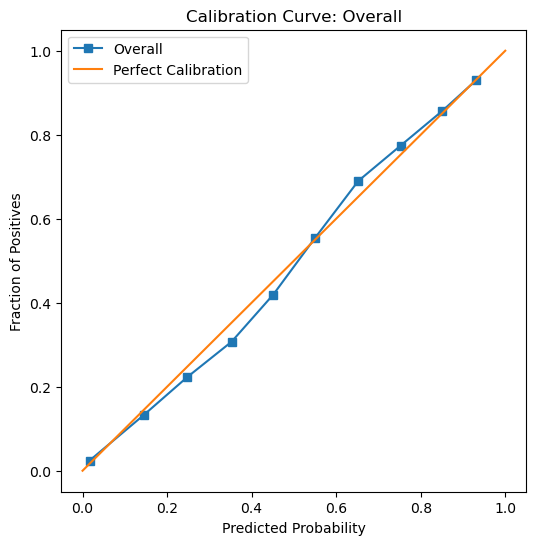

In [47]:
# So we need to first calculate our y_prob: predicted probability for the positive class
y_prob = grid.predict_proba(X_test)[:, 1]

# Overall calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, label="Overall")
plt.plot([0, 1], [0, 1], label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve: Overall")
plt.legend()
plt.show()

**Calibration Curve by Group:**

* Our graph below shows our calibration curve broken down by race group. Each colored line corresponds to a different group’s predicted probabilities versus their actual outcomes.We can see in our graph that Group 1 (White) appears relatively close to the diagonal for most probability ranges, suggesting good calibration. Group 2 (Black/African American) shows more fluctuation, especially in the mid-probability range, indicating that the model’s predicted probabilities for this group deviate more from perfect calibration. Groups with fewer samples (such as Groups 5, 7, and 9) have jagged lines, which likely stems from limited data. Looking at these deviations is important for understanding and addressing potential fairness issues across all groups.

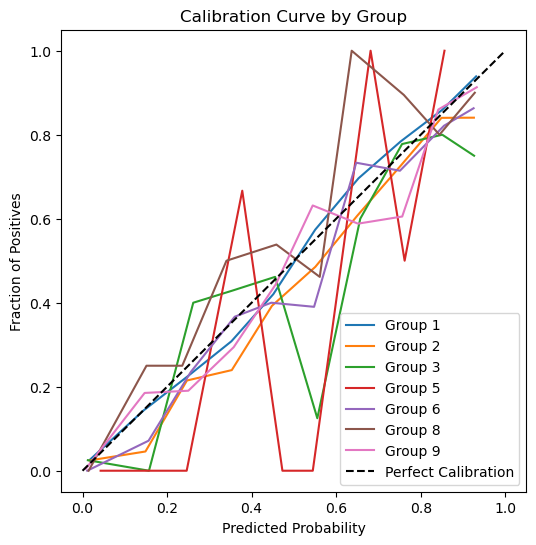

In [49]:
groups = np.unique(group_test)
plt.figure(figsize=(6, 6))
for g in groups:
    idx = (group_test == g)
    # If there are very few samples for this group, skip
    if np.sum(idx) < 10:
        continue
    prob_true_g, prob_pred_g = calibration_curve(y_test[idx], y_prob[idx], n_bins=10)
    plt.plot(prob_pred_g, prob_true_g,  label=f"Group {g}")
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve by Group")
plt.legend()
plt.show()

**Error Rate Balance**

* Our error rate balance shows that overall, our model misses about 15.4% of employed individuals (FNR) and incorrectly predicts employment for 19.3% of unemployed individuals (FPR). For Group 1 (White individuals), the rates are very similar—15.2% FNR and 19.2% FPR. In contrast, Group 2 (Black individuals) has slightly higher error rates, with an FNR of 17.2% and an FPR of 19.5%. Other groups, particularly those with fewer samples, exhibit more variability: for example, Group 3 shows a 25% FNR and 24% FPR, while Group 6 (Asian individuals) has a low FNR (11.1%) but a higher FPR (27.6%). These differences indicate that our model does not achieve perfect error rate balance across all groups, highlighting areas where bias may be present in predicting employment status.


In [50]:
def get_fnr_fpr(y_true, y_pred):
    """Compute FNR and FPR for given true and predicted labels."""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    return fnr, fpr

# Overall FNR/FPR
overall_fnr, overall_fpr = get_fnr_fpr(y_test, grid.predict(X_test))
print(f"Overall FNR: {overall_fnr:.3f}")
print(f"Overall FPR: {overall_fpr:.3f}")

# By-group FNR/FPR
for g in groups:
    idx = (group_test == g)
    y_true_g = y_test[idx]
    y_pred_g = grid.predict(X_test[idx])
    fnr_g, fpr_g = get_fnr_fpr(y_true_g, y_pred_g)
    print(f"Group {g} FNR: {fnr_g:.3f}, FPR: {fpr_g:.3f}")

Overall FNR: 0.154
Overall FPR: 0.193
Group 1 FNR: 0.152, FPR: 0.192
Group 2 FNR: 0.172, FPR: 0.195
Group 3 FNR: 0.250, FPR: 0.244
Group 5 FNR: 0.286, FPR: 0.286
Group 6 FNR: 0.111, FPR: 0.276
Group 7 FNR: nan, FPR: 0.333
Group 8 FNR: 0.195, FPR: 0.188
Group 9 FNR: 0.185, FPR: 0.139


**Statistical Parity Test**

* Our statistical parity analysis shows that, overall, our model predicts employment for about 48.4% of individuals. However, when we break it down by race, we see notable differences that raise fairness concerns. For example, Group 1 (White individuals) has a predicted employment rate of 49.3%, whereas Group 2 (Black individuals) is lower at 42.6%. Other groups vary as well—Group 6 (Asian individuals) has a higher rate of 55.7%, while Groups 7 and 9 have much lower rates (33.3% and 34.9%, respectively). These disparities in predicted positive rates suggest that our model may favor some groups over others, which is a critical issue in auditing fairness.

In [51]:
y_pred = grid.predict(X_test)

# Overall predicted positive rate
overall_positive_rate = np.mean(y_pred)
print(f"\nOverall Predicted Positive Rate: {overall_positive_rate:.3f}")

# By-group predicted positive rate
for g in groups:
    idx = (group_test == g)
    group_positive_rate = np.mean(y_pred[idx])
    print(f"Group {g} Predicted Positive Rate: {group_positive_rate:.3f}")


Overall Predicted Positive Rate: 0.484
Group 1 Predicted Positive Rate: 0.493
Group 2 Predicted Positive Rate: 0.426
Group 3 Predicted Positive Rate: 0.437
Group 5 Predicted Positive Rate: 0.429
Group 6 Predicted Positive Rate: 0.557
Group 7 Predicted Positive Rate: 0.333
Group 8 Predicted Positive Rate: 0.500
Group 9 Predicted Positive Rate: 0.349


**Feasible FNR and FPR rates interpretation**

In our graph each colored line shows all (FNR, FPR) combinations that would achieve a fixed positive predictive value (PPV) for a given group, based on that group’s prevalence. The circular markers indicate our model’s actual (FNR, FPR).

* Group 1 (White): Its feasible line illustrates how changing the threshold could shift its false negative rate (FNR) and false positive rate (FPR).

* Group 2 (Black): Has its own feasible line, which typically differs because of a higher prevalence (more individuals in the group are actually employed) and/or different PPV requirements.

If we tried to make FPR the same for both groups (say, moving Group 2’s marker to Group 1’s FPR), we would generally need to increase Group 2’s FNR. That means more Black individuals who are actually employed would be missed by the model—an important trade-off for fairness. Essentially, achieving equal FPR across groups often comes at the cost of raising FNR for at least one group, which can exacerbate disparities in missed positives. This plot helps us visualize how much we’d have to adjust each group’s threshold to meet that fairness goal, and how it could impact different groups in our dataset.

In the figure below, each colored line shows the combinations of false negative rate (FNR) and false positive rate (FPR) that would achieve the same positive predictive value (PPV) for a particular group, given its prevalence. The colored dots represent our model’s actual (FNR, FPR) for each group. Notably, some groups’ actual points lie close to their feasible lines, meaning only minor threshold adjustments would be required to change their FPR or FNR. However, for groups where the actual point is far from the feasible line (e.g., Group 2), forcing a lower FPR would require a significant increase in FNR. In practical terms, that means we would miss many more truly employed individuals from that group. This highlights the inherent trade-off between equalizing FPR across groups and maintaining a reasonable FNR, especially when group prevalences differ.

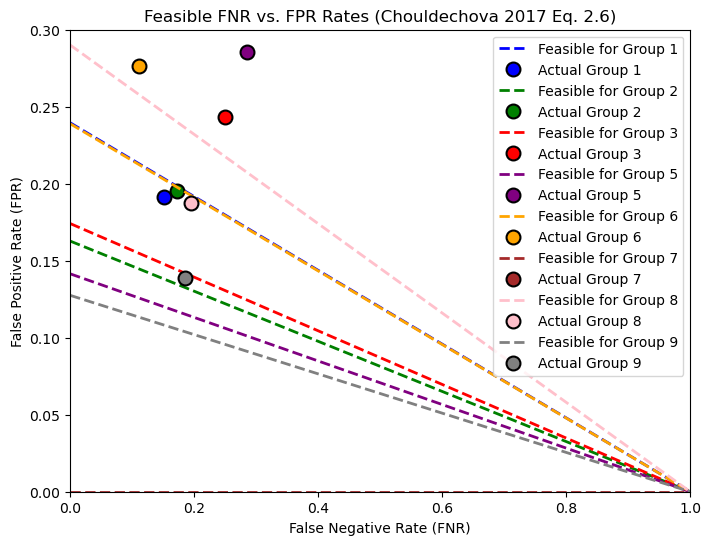

In [68]:
color_map = {
    1: "blue",
    2: "green",
    3: "red",
    5: "purple",
    6: "orange",
    7: "brown",
    8: "pink",
    9: "gray"
}

fpr_lines = {}
fpr_actual = {}
for g in groups:
    idx = (group_test == g)
    # Prevalence: proportion of true positives in group g
    p = np.mean(y_test[idx])
    fnr_range = np.linspace(0, 1, 100)
    PPV_desired = overall_ppv  # fixed desired PPV
    # Compute feasible FPR using Eq. (2.6)
    fpr_line = np.where((1 - p) > 0, ((1 - fnr_range) * p * (1/PPV_desired - 1)) / (1 - p), np.nan)
    fpr_lines[g] = (fnr_range, fpr_line)
    
    # Get actual FNR and FPR from group_metrics
    for metric in group_metrics:
        if metric['group'] == g:
            fpr_actual[g] = (metric['fnr'], metric['fpr'])
            break

# Plot the feasible FNR-FPR lines and actual points with consistent colors
plt.figure(figsize=(8, 6))
for g, (fnr_range, fpr_line) in fpr_lines.items():
    plt.plot(fnr_range, fpr_line, linestyle='--', linewidth=2,
             label=f"Feasible for Group {g}", color=color_map.get(g, "black"))
    if g in fpr_actual:
        actual_fnr, actual_fpr = fpr_actual[g]
        plt.plot(actual_fnr, actual_fpr, "o", markersize=10, 
                 markeredgecolor='black', markeredgewidth=1.5,
                 color=color_map.get(g, "black"), 
                 label=f"Actual Group {g}")
        
plt.xlabel("False Negative Rate (FNR)")
plt.ylabel("False Positive Rate (FPR)")
plt.title("Feasible FNR vs. FPR Rates (Chouldechova 2017 Eq. 2.6)")
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 0.3])  # Limit the y-axis to 0.3 for better visibility
plt.show()

## Interpreting FNR Changes to Equalize FPR:
From the feasible lines, we see how each group’s false negative rate (FNR) would have to shift if we wanted all groups to share the same false positive rate (FPR). For example, if Group 2’s actual FPR is higher than Group 1’s, lowering it to match Group 1’s level would require moving Group 2’s marker along its feasible line toward a lower FPR. This shift, however, pushes the marker toward a much higher FNR—often much higher than the group’s current FNR. In other words, this means that, to reduce Group 2’s false positives, we would end up missing many more truly employed individuals (i.e., a spike in FNR). Each group’s line tells a similar story: matching another group’s FPR typically demands a noticeable trade-off in FNR, underscoring the difficulty of balancing error rates across groups when their underlying prevalence differs.


## **Concluding Discussion**

Our project aimed to predict whether an individual is employed using demographic data from the ACS PUMS dataset. Systems like this could benefit various stakeholders. For example, companies in human resources or financial services might use such a model to assess employment status quickly and efficiently. Government agencies could also deploy this system to better understand labor market trends or to guide social policy. Essentially, any organization that needs insights into employment patterns could find value in our approach.

However, our bias audit revealed important fairness challenges. Although the model is overall well-calibrated—meaning its predicted probabilities match real-world outcomes—it shows differences in error rates across racial groups. Group 1 (White individuals) and Group 2 (Black individuals) have similar overall accuracy, but Black individuals experience a higher false negative rate, indicating that more truly employed individuals are being missed by the model. This disparity in error rates is critical; deploying such a model at scale might inadvertently disadvantage Black individuals, leading to biased outcomes in decision-making processes.

Beyond bias in error rates, there are other potential concerns. Even if calibration is good, uneven predicted positive rates suggest that the model may favor one group over another, undermining fairness. Moreover, issues such as data quality, changes over time, and the potential misuse of the model in sensitive contexts (e.g., employment or credit scoring) could further compound these problems. To address these concerns, it is important to continue refining the model, incorporate more diverse and representative data, and establish robust monitoring and adjustment procedures when the model is deployed in real-world settings.